## データ準備

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.5.0


In [2]:
NUM_WORDS = 10000

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

train_data

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 8255, 78, 228,

In [3]:
# [3, 1, 4] ==> [0, 1, 0, 1, 1, 0, ..., 0]
def multi_hot_sequences(sequences, dimension):
  # 形状が (len(sequences), dimension)ですべて0の行列を作る
  results = np.zeros((len(sequences), dimension))
  for i, word_indices in enumerate(sequences):
    results[i, word_indices] = 1.0  # 特定のインデックスに対してresults[i] を１に設定する
  return results


train_data = multi_hot_sequences(train_data, dimension=NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension=NUM_WORDS)

train_data

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

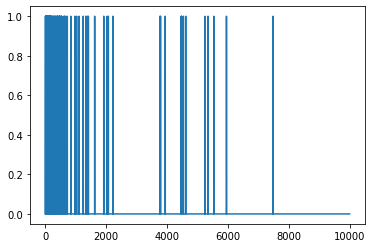

In [4]:
plt.plot(train_data[0])

In [7]:
def plot_history(histories, key='binary_crossentropy'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])

## 過学習のデモ

### 比較基準となるモデル

In [9]:
baseline_model = keras.Sequential([
    # `.summary` を見るために`input_shape`が必要 
    keras.layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])

baseline_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [10]:
baseline_history = baseline_model.fit(train_data,
                                      train_labels,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(test_data, test_labels),
                                      verbose=2)

Epoch 1/20
49/49 - 2s - loss: 0.4685 - accuracy: 0.8168 - binary_crossentropy: 0.4685 - val_loss: 0.3285 - val_accuracy: 0.8768 - val_binary_crossentropy: 0.3285
Epoch 2/20
49/49 - 1s - loss: 0.2449 - accuracy: 0.9108 - binary_crossentropy: 0.2449 - val_loss: 0.2829 - val_accuracy: 0.8865 - val_binary_crossentropy: 0.2829
Epoch 3/20
49/49 - 1s - loss: 0.1804 - accuracy: 0.9353 - binary_crossentropy: 0.1804 - val_loss: 0.2911 - val_accuracy: 0.8837 - val_binary_crossentropy: 0.2911
Epoch 4/20
49/49 - 1s - loss: 0.1452 - accuracy: 0.9515 - binary_crossentropy: 0.1452 - val_loss: 0.3088 - val_accuracy: 0.8808 - val_binary_crossentropy: 0.3088
Epoch 5/20
49/49 - 1s - loss: 0.1203 - accuracy: 0.9605 - binary_crossentropy: 0.1203 - val_loss: 0.3381 - val_accuracy: 0.8748 - val_binary_crossentropy: 0.3381
Epoch 6/20
49/49 - 1s - loss: 0.1009 - accuracy: 0.9690 - binary_crossentropy: 0.1009 - val_loss: 0.3684 - val_accuracy: 0.8702 - val_binary_crossentropy: 0.3684
Epoch 7/20
49/49 - 1s - loss

### 比較対象より小さいモデル

In [7]:
smaller_model = keras.Sequential([
    keras.layers.Dense(4, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

smaller_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy', 'binary_crossentropy'])

smaller_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


In [8]:
smaller_history = smaller_model.fit(train_data,
                                    train_labels,
                                    epochs=20,
                                    batch_size=512,
                                    validation_data=(test_data, test_labels),
                                    verbose=2)

Epoch 1/20
49/49 - 2s - loss: 0.6045 - accuracy: 0.7000 - binary_crossentropy: 0.6045 - val_loss: 0.5442 - val_accuracy: 0.7950 - val_binary_crossentropy: 0.5442
Epoch 2/20
49/49 - 1s - loss: 0.4944 - accuracy: 0.8483 - binary_crossentropy: 0.4944 - val_loss: 0.4956 - val_accuracy: 0.8452 - val_binary_crossentropy: 0.4956
Epoch 3/20
49/49 - 1s - loss: 0.4450 - accuracy: 0.8909 - binary_crossentropy: 0.4450 - val_loss: 0.4722 - val_accuracy: 0.8581 - val_binary_crossentropy: 0.4722
Epoch 4/20
49/49 - 1s - loss: 0.4113 - accuracy: 0.9137 - binary_crossentropy: 0.4113 - val_loss: 0.4635 - val_accuracy: 0.8540 - val_binary_crossentropy: 0.4635
Epoch 5/20
49/49 - 1s - loss: 0.3838 - accuracy: 0.9286 - binary_crossentropy: 0.3838 - val_loss: 0.4469 - val_accuracy: 0.8740 - val_binary_crossentropy: 0.4469
Epoch 6/20
49/49 - 1s - loss: 0.3611 - accuracy: 0.9398 - binary_crossentropy: 0.3611 - val_loss: 0.4396 - val_accuracy: 0.8759 - val_binary_crossentropy: 0.4396
Epoch 7/20
49/49 - 1s - loss

### 比較対象より大きいモデル

In [9]:
bigger_model = keras.models.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

bigger_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy','binary_crossentropy'])

bigger_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________


In [10]:
bigger_history = bigger_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Epoch 1/20
49/49 - 11s - loss: 0.3552 - accuracy: 0.8443 - binary_crossentropy: 0.3552 - val_loss: 0.2841 - val_accuracy: 0.8837 - val_binary_crossentropy: 0.2841
Epoch 2/20
49/49 - 11s - loss: 0.1361 - accuracy: 0.9515 - binary_crossentropy: 0.1361 - val_loss: 0.3278 - val_accuracy: 0.8762 - val_binary_crossentropy: 0.3278
Epoch 3/20
49/49 - 10s - loss: 0.0403 - accuracy: 0.9886 - binary_crossentropy: 0.0403 - val_loss: 0.4598 - val_accuracy: 0.8658 - val_binary_crossentropy: 0.4598
Epoch 4/20
49/49 - 11s - loss: 0.0059 - accuracy: 0.9992 - binary_crossentropy: 0.0059 - val_loss: 0.6036 - val_accuracy: 0.8686 - val_binary_crossentropy: 0.6036
Epoch 5/20
49/49 - 11s - loss: 0.0012 - accuracy: 0.9999 - binary_crossentropy: 0.0012 - val_loss: 0.6937 - val_accuracy: 0.8703 - val_binary_crossentropy: 0.6937
Epoch 6/20
49/49 - 11s - loss: 4.4559e-04 - accuracy: 1.0000 - binary_crossentropy: 4.4559e-04 - val_loss: 0.7335 - val_accuracy: 0.8703 - val_binary_crossentropy: 0.7335
Epoch 7/20
49/

### 訓練時と検証時の損失グラフ

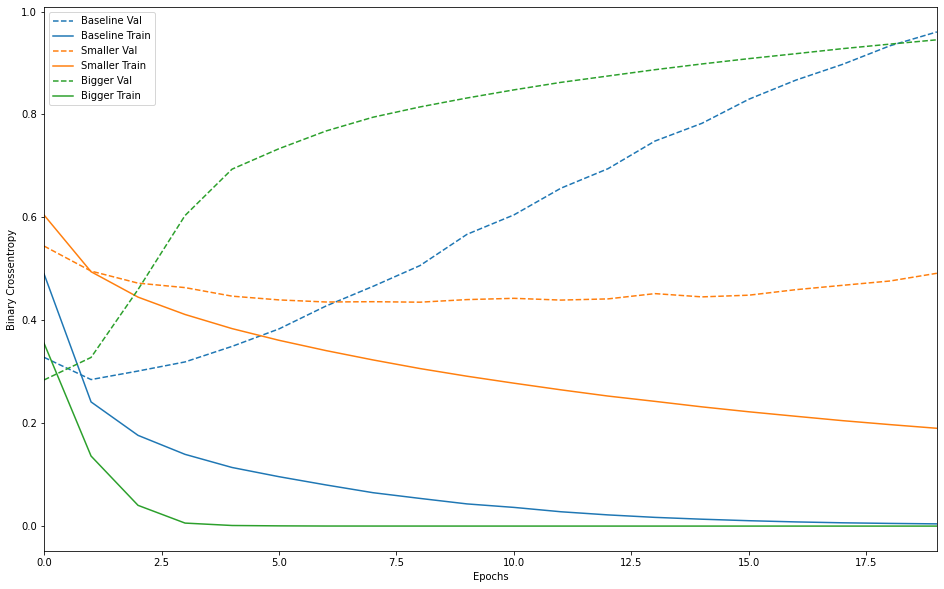

In [11]:
plot_history([('baseline', baseline_history),
              ('smaller', smaller_history),
              ('bigger', bigger_history)])

### 精度評価

In [12]:
baseline_model.evaluate(test_data,  test_labels, verbose=2)
smaller_model.evaluate(test_data, test_labels, verbose=2)
bigger_model.evaluate(test_data, test_labels, verbose=2)

782/782 - 1s - loss: 0.9605 - accuracy: 0.8482 - binary_crossentropy: 0.9605
782/782 - 1s - loss: 0.4914 - accuracy: 0.8614 - binary_crossentropy: 0.4914
782/782 - 6s - loss: 0.9451 - accuracy: 0.8701 - binary_crossentropy: 0.9451


[0.9451071619987488, 0.8701199889183044, 0.9451071619987488]

In [13]:
# RAM削減のためモデル削除
del bigger_model
del smaller_model
del bigger_history
del smaller_history

## 過学習の防止

### 重みの正則化を追加

In [14]:
l2_model = keras.models.Sequential([
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001), # 0.001*重み係数の値**2をネットワークの損失合計に加算
                       activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

l2_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'binary_crossentropy'])

l2_model_history = l2_model.fit(train_data, train_labels,
                                epochs=20,
                                batch_size=512,
                                validation_data=(test_data, test_labels),
                                verbose=2)

Epoch 1/20
49/49 - 2s - loss: 0.5157 - accuracy: 0.8078 - binary_crossentropy: 0.4753 - val_loss: 0.3707 - val_accuracy: 0.8766 - val_binary_crossentropy: 0.3296
Epoch 2/20
49/49 - 1s - loss: 0.2973 - accuracy: 0.9087 - binary_crossentropy: 0.2518 - val_loss: 0.3332 - val_accuracy: 0.8868 - val_binary_crossentropy: 0.2843
Epoch 3/20
49/49 - 1s - loss: 0.2473 - accuracy: 0.9305 - binary_crossentropy: 0.1958 - val_loss: 0.3412 - val_accuracy: 0.8836 - val_binary_crossentropy: 0.2876
Epoch 4/20
49/49 - 1s - loss: 0.2232 - accuracy: 0.9424 - binary_crossentropy: 0.1676 - val_loss: 0.3626 - val_accuracy: 0.8775 - val_binary_crossentropy: 0.3056
Epoch 5/20
49/49 - 1s - loss: 0.2093 - accuracy: 0.9484 - binary_crossentropy: 0.1508 - val_loss: 0.3661 - val_accuracy: 0.8789 - val_binary_crossentropy: 0.3066
Epoch 6/20
49/49 - 1s - loss: 0.1963 - accuracy: 0.9542 - binary_crossentropy: 0.1358 - val_loss: 0.3858 - val_accuracy: 0.8738 - val_binary_crossentropy: 0.3246
Epoch 7/20
49/49 - 1s - loss

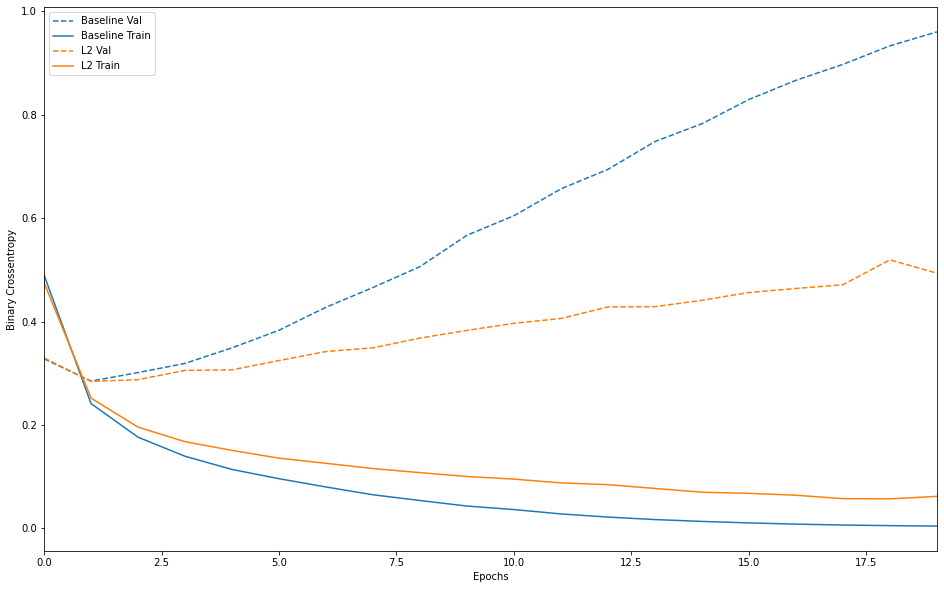

In [15]:
plot_history([('baseline', baseline_history),
              ('l2', l2_model_history)])

### ドロップアウト追加

In [16]:
dpt_model = keras.models.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dropout(0.5),  # Dropout率は通常0.2-0.5
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

dpt_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy','binary_crossentropy'])

dpt_model_history = dpt_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Epoch 1/20
49/49 - 2s - loss: 0.6398 - accuracy: 0.6220 - binary_crossentropy: 0.6398 - val_loss: 0.5193 - val_accuracy: 0.8496 - val_binary_crossentropy: 0.5193
Epoch 2/20
49/49 - 1s - loss: 0.4698 - accuracy: 0.7928 - binary_crossentropy: 0.4698 - val_loss: 0.3434 - val_accuracy: 0.8812 - val_binary_crossentropy: 0.3434
Epoch 3/20
49/49 - 1s - loss: 0.3601 - accuracy: 0.8595 - binary_crossentropy: 0.3601 - val_loss: 0.2895 - val_accuracy: 0.8890 - val_binary_crossentropy: 0.2895
Epoch 4/20
49/49 - 1s - loss: 0.2943 - accuracy: 0.8933 - binary_crossentropy: 0.2943 - val_loss: 0.2774 - val_accuracy: 0.8870 - val_binary_crossentropy: 0.2774
Epoch 5/20
49/49 - 1s - loss: 0.2591 - accuracy: 0.9075 - binary_crossentropy: 0.2591 - val_loss: 0.2777 - val_accuracy: 0.8878 - val_binary_crossentropy: 0.2777
Epoch 6/20
49/49 - 1s - loss: 0.2235 - accuracy: 0.9209 - binary_crossentropy: 0.2235 - val_loss: 0.2888 - val_accuracy: 0.8863 - val_binary_crossentropy: 0.2888
Epoch 7/20
49/49 - 1s - loss

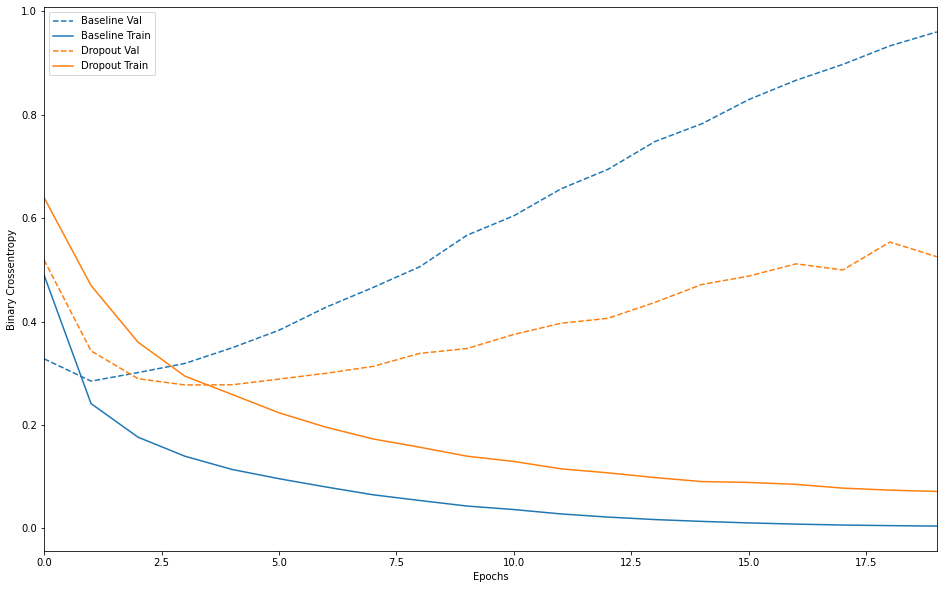

In [17]:
plot_history([('baseline', baseline_history),
              ('dropout', dpt_model_history)])

### 精度評価

In [18]:
l2_model.evaluate(test_data,  test_labels, verbose=2)
dpt_model.evaluate(test_data, test_labels, verbose=2)

782/782 - 1s - loss: 0.5671 - accuracy: 0.8544 - binary_crossentropy: 0.4937
782/782 - 1s - loss: 0.5255 - accuracy: 0.8751 - binary_crossentropy: 0.5255


[0.5254726409912109, 0.8751199841499329, 0.5254726409912109]

In [19]:
del l2_model
del dpt_model
del l2_model_history
del dpt_model_history

## 重みの正則化とドロップアウトのハイブリッド

In [5]:
model = keras.models.Sequential([
  keras.layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,),
                     kernel_regularizer=keras.regularizers.l2(0.001)),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(16, activation='relu',
                     kernel_regularizer=keras.regularizers.l2(0.001)),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'binary_crossentropy'])

model_history = model.fit(train_data, train_labels,
                          epochs=20,
                          batch_size=512,
                          validation_data=(test_data, test_labels),
                          verbose=2)

Epoch 1/20
49/49 - 2s - loss: 0.6499 - accuracy: 0.6567 - binary_crossentropy: 0.6115 - val_loss: 0.4864 - val_accuracy: 0.8587 - val_binary_crossentropy: 0.4485
Epoch 2/20
49/49 - 1s - loss: 0.4697 - accuracy: 0.8211 - binary_crossentropy: 0.4280 - val_loss: 0.3659 - val_accuracy: 0.8832 - val_binary_crossentropy: 0.3194
Epoch 3/20
49/49 - 1s - loss: 0.3834 - accuracy: 0.8770 - binary_crossentropy: 0.3329 - val_loss: 0.3411 - val_accuracy: 0.8839 - val_binary_crossentropy: 0.2868
Epoch 4/20
49/49 - 1s - loss: 0.3363 - accuracy: 0.8999 - binary_crossentropy: 0.2787 - val_loss: 0.3352 - val_accuracy: 0.8887 - val_binary_crossentropy: 0.2745
Epoch 5/20
49/49 - 1s - loss: 0.3066 - accuracy: 0.9175 - binary_crossentropy: 0.2431 - val_loss: 0.3477 - val_accuracy: 0.8826 - val_binary_crossentropy: 0.2817
Epoch 6/20
49/49 - 1s - loss: 0.2923 - accuracy: 0.9238 - binary_crossentropy: 0.2240 - val_loss: 0.3541 - val_accuracy: 0.8865 - val_binary_crossentropy: 0.2839
Epoch 7/20
49/49 - 1s - loss

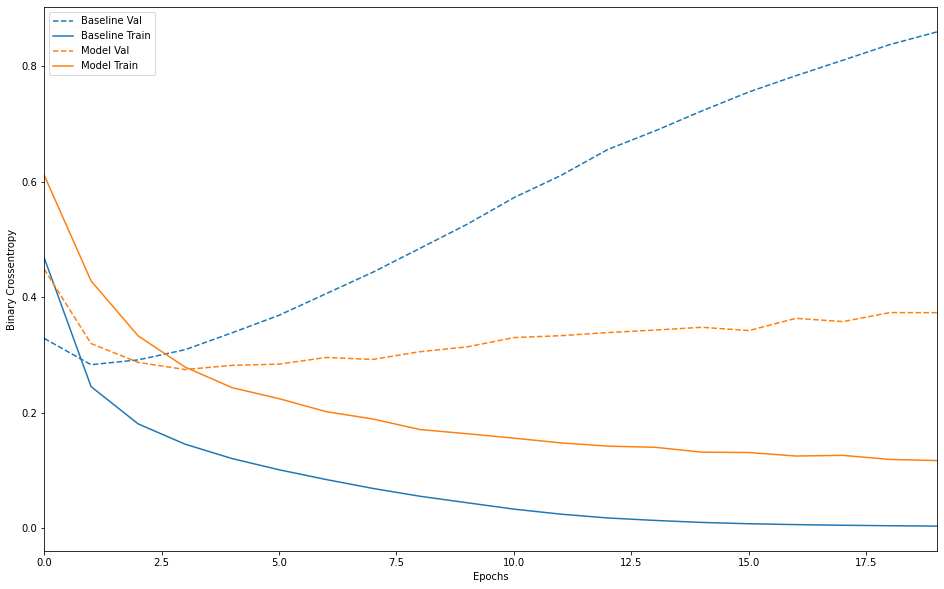

In [11]:
plot_history([('baseline', baseline_history),
              ('model', model_history)])

In [6]:
model.evaluate(test_data,  test_labels, verbose=2)

782/782 - 1s - loss: 0.4686 - accuracy: 0.8764 - binary_crossentropy: 0.3730


[0.46861234307289124, 0.8764399886131287, 0.37295791506767273]